In [36]:
# install these libraries before proceeding
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install wordcloud
# !pip3 install nltk
# !pip3 install matplotlib
# !pip3 install nltk

In [37]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
#from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from collections import Counter
from collections import OrderedDict
import re
import os

In [38]:
# uncomment the below line to download english stopwords
#nltk.download('stopwords')

## Util 

In [39]:
def custom_display(txt):
    display(HTML("<h2>" + txt + "</h2>"))
    print("_____"*23)

def sort_by_values(data, reverse=True):
    return OrderedDict(sorted(data.items(), key=lambda t: t[1], reverse=True))

def plot_bar_chart(total_items, y_values, x_values, title, xlabel, ylabel, rotation=0):
    plt.figure(figsize=(18,10))
    plt.bar(np.arange(total_items), y_values,color=['violet','indigo','blue','green', 'yellow', 'orange','red' ])
    plt.xticks(np.arange(total_items),x_values,rotation=rotation)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def get_regex_user_name(name):
    return name.replace(' ', '\s').replace('|', '\|')

In [40]:
# if you are using google colab, then import your WhatsApp txt file from following code
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

# uncomment the following lines to see the files in the current directory
# files.os.listdir()

In [43]:
file_path = 'input_file.txt'  # replace the file name by your file name/path

# Open the file in read mode with UTF-8 encoding
try:
    with open(file_path, "r", encoding="utf8") as fh:
        # Read the entire content of the file
        data = fh.read()
        
    # Check if the file is not empty
    if data:
        # Check if the first character of the data is a '['
        is_iphone = data[0] == '['

        # If the condition is true, replace non-breaking spaces with regular spaces
        if is_iphone:
            data = data.replace('\xa0', ' ')

        # Optionally, you can print the data or perform further processing here
        print(data)
    else:
        print("The file is empty.")

except FileNotFoundError:
    print(f"The file {file_path} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

The file input_file.txt does not exist.


## Getting datetime & user name from the text file

In [44]:
# various time format
# iPhone
    # [14/06/18, 12:47:32] ‪user_name‬: message
    # [14/06/18, 3:25:32 PM] ‪user_name: message
# Android 
    # 19/02/18, 10:27 PM - user_name: message
    # 05/11/17, 09:33 - user_name: message

In [46]:
def create_date_time_user_name(time_and_names, is_24_hour_format):
    date_time_user_name = [] # will be array of ('19/02/18', '23:28:00', 'Kalsi')
    if is_24_hour_format:
        if is_iphone:
            # time_and_names is array of type "[02/07/18, 12:59:07] user_name:"
            for time_name in time_and_names:
                time_name = time_name.split(']')
                date_time = time_name[0][1:] #02/07/18, 12:59:07
                date_ = date_time.split(',')[0].strip() #02/07/18, dd/mm/yy
                time_ = date_time.split(',')[1].strip() #12:59:07
                time_ = time_.split(':')[0] + ':' +time_.split(':')[1]#12:59
                user_name = time_name[1][:-1].strip() # user_name
                date_time_user_name.append((date_,time_,user_name))
        else:
            # time_and_names is array of type '02/11/17, 10:52 - user_name:'
            for time_name in time_and_names:
                time_name = time_name.split(' - ')# ['02/11/17, 10:52', 'user_name:']
                date_time = time_name[0] #02/07/18, 12:59
                date_ = date_time.split(', ')[0].strip() #02/07/18
                time_ = date_time.split(', ')[1].strip() #12:59
                user_name = time_name[1][:-1].strip() # user_name
                date_time_user_name.append((date_,time_,user_name))    
    else:
        if is_iphone:
            # [14/06/18, 3:25:32 PM] \u202a+91 98801 23040\u202c:', 'PM')
            for time_name, meridian in time_and_names:
                date_time = time_name.split('] ')[0] # [14/06/18, 3:25:32 PM
                name_ = time_name.split('] ')[1][:-1] #user_name
                date_ = date_time.split(', ')[0][1:]# 19/02/18
                time_ = date_time.split(', ')[1].split(' ')[0] # 3:25:32
                time_ = time_.split(':')[0] + ':' +time_.split(':')[1]#3:25
                hour_ = int(time_.split(':')[0])
                minute_ = time_.split(':')[1]
                if (meridian == 'PM') and (hour_ != 12):
                    hour_ += 12
                if (meridian == 'AM') and (hour_ == 12):
                    hour_=0
#                 hour_ -= 1
                if hour_ < 10:
                    hour_ = "0"+str(hour_)
                final_time = str(hour_) + ":" + str(minute_)
                date_time_user_name.append((date_,final_time, name_ ))
        else:
            # '19/02/18, 9:44 PM - user_name:', 'PM')
            for time_name, meridian in time_and_names:
                date_time = time_name.split(' - ')[0] # 19/02/18, 9:44 PM
                name_ = time_name.split(' - ')[1][:-1] # remove the last character i.e, ':' to get the user_name
                date_ = date_time.split(', ')[0]# 19/02/18
                time_ = date_time.split(', ')[1].split(' ')[0] # 9:44
                hour_ = int(time_.split(':')[0])
                minute_ = time_.split(':')[1]
                if (meridian == 'PM') and (hour_ != 12):
                    hour_ += 12
                if (meridian == 'AM') and (hour_ == 12):
                    hour_=0                    
#                 hour_ -= 1
                if hour_ < 10:
                    hour_ = "0"+str(hour_)
                final_time = str(hour_) + ":" + str(minute_)
                date_time_user_name.append((date_,final_time, name_ ))
    return date_time_user_name

In [47]:
def get_date_time_user_name_data():
    is_24_hour_format = False
    if is_iphone:
        # check for AM/PM
        time_and_names = re.findall(r'(\[\d{1,2}/\d{1,2}/\d{1,2},\s\d{1,2}:\d{1,2}:\d{1,2}\s(PM|AM)\]\s.*?:)', data)[1:]
        if len(time_and_names) == 0:
            is_24_hour_format = True
            time_and_names = re.findall(r'(\[\d{1,2}/\d{1,2}/\d{1,2},\s\d{1,2}:\d{1,2}:\d{1,2}\]\s.*?:)', data)[1:]
    else:
        # check for AM/PM
        time_and_names = re.findall(r'(\d{1,2}/\d{1,2}/\d{1,2},\s\d{1,2}:\d{1,2}\s(PM|AM)\s-\s.*?:)', data)
        if len(time_and_names) == 0:
            is_24_hour_format = True
            time_and_names = re.findall(r'(\d{1,2}/\d{1,2}/\d{1,2},\s\d{1,2}:\d{1,2}\s-\s.*?:)', data)
    return create_date_time_user_name(time_and_names, is_24_hour_format)

In [48]:
def get_message_timings():
    users = {}
    message_timings = {}
    date_time_user_name = get_date_time_user_name_data()
    for date_, time_, name_ in date_time_user_name:
        name_ = name_.strip('\u202c').strip('\u202a')
        if name_ in users.keys():
            users[name_]+=1
        else:
            users[name_]=1
        hour = time_.split(':')[0]
        if hour not in message_timings.keys():
            message_timings[hour] = 0
        message_timings[hour] += 1
    return users, message_timings

In [50]:
def get_message_timings():
    # Example data
    users = ["user1", "user2", "user3"]
    message_timings = ["2024-06-16 08:00:00", "2024-06-16 09:00:00", "2024-06-16 10:00:00"]
    return users, message_timings

# Call the function and assign the returned values to users and message_timings
users, message_timings = get_message_timings()

# Print the results to verify
print("Users:", users)
print("Message Timings:", message_timings)


Users: ['user1', 'user2', 'user3']
Message Timings: ['2024-06-16 08:00:00', '2024-06-16 09:00:00', '2024-06-16 10:00:00']


## Peak hour of chat

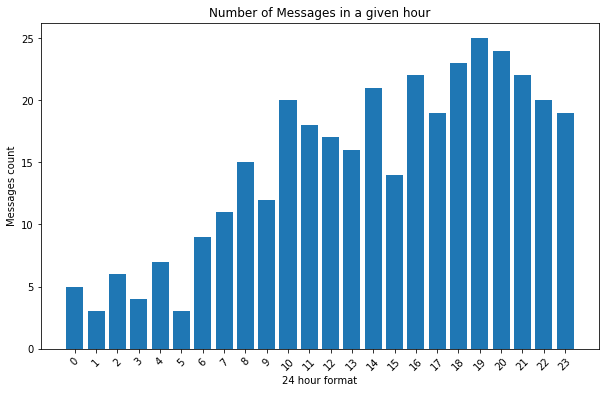

Chats will be more during 19:00 hours


In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Example of message_timings dictionary
# message_timings = {0: 5, 1: 3, 2: 6, 3: 4, ..., 23: 8}

def plot_bar_chart(length, counts, labels, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(range(length), counts, tick_label=labels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

def custom_display(message):
    print(message)

# Example message_timings dictionary, replace it with your actual data
message_timings = {0: 5, 1: 3, 2: 6, 3: 4, 4: 7, 5: 3, 6: 9, 7: 11, 8: 15, 9: 12, 10: 20, 11: 18, 12: 17, 13: 16, 14: 21, 15: 14, 16: 22, 17: 19, 18: 23, 19: 25, 20: 24, 21: 22, 22: 20, 23: 19}

# Extracting and sorting the hours
hours = sorted(message_timings.keys())

# Extracting the message counts corresponding to the sorted hours
message_counts = [message_timings[hour] for hour in hours]

# Plotting the bar chart
plot_bar_chart(len(hours), message_counts, hours, 'Number of Messages in a given hour', '24 hour format', 'Messages count')

# Displaying the custom message
custom_display("Chats will be more during " + str(hours[np.argmax(message_counts)]) + ":00 hours")


# Frequency of messages by Users

In [57]:
import pandas as pd
import numpy as np

# Example users dictionary, replace it with your actual data
# Ensure that users is defined as a dictionary
users = {'user1': 10, 'user2': 15, 'user3': 5, 'user4': 20}

# Check if 'users' is a dictionary
if isinstance(users, dict):
    # Create a DataFrame from the users dictionary
    users_df = pd.DataFrame({
        'id': np.arange(len(users)), 
        'user': list(users.keys()), 
        'messages': list(users.values())
    })

    # Sort the DataFrame based on the 'messages' column in descending order
    users_df = users_df.sort_values(['messages'], ascending=False)

    # Calculate the total number of active users
    total_active_users = users_df.shape[0]

    # Display the result
    print(f'Total active users: {total_active_users}')
    print(users_df)
else:
    print("Error: 'users' should be a dictionary with user names as keys and message counts as values.")




Total active users: 4
   id   user  messages
3   3  user4        20
1   1  user2        15
0   0  user1        10
2   2  user3         5


In [61]:
import re
import pandas as pd

# Example users_df, replace it with your actual DataFrame
# users_df = pd.DataFrame({'user': ['user1', 'user2', 'user3'], 'messages': [10, 15, 5]})

# Example data, replace it with your actual data string
data = "Here is some text with a link: https://example.com and <Media omitted> and another link http://example.org"

# Calculate total messages
total_msgs = users_df['messages'].sum()

# Determine if it is iPhone
is_iphone = True  # Change accordingly

# Calculate total media omissions based on device
if is_iphone:
    total_medias = len(re.findall(r'image omitted', data)) + len(re.findall(r'video omitted', data))
else:
    total_medias = len(re.findall(r'<Media omitted>', data))

# Extract hyperlinks from data
hyper_links = re.findall(r'(http[s]?://[^\s\n]+)', data)

# Display results
print(f'Total messages: {total_msgs}')
print(f'Total media omissions: {total_medias}')
print(f'Hyperlinks found: {hyper_links}')


Total messages: 50
Total media omissions: 0
Hyperlinks found: ['https://example.com', 'http://example.org']


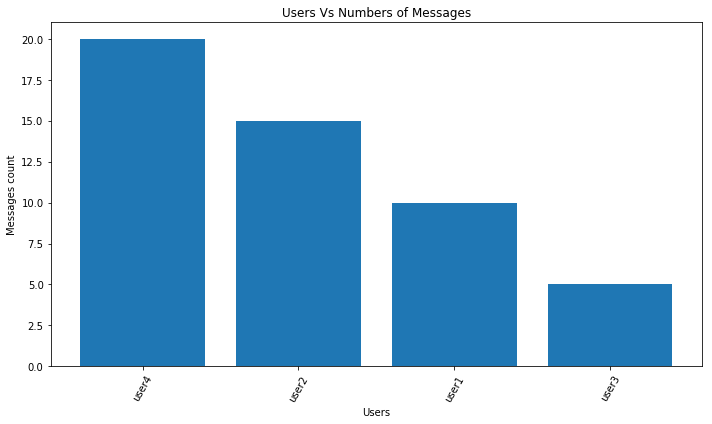

user4 messaged the most with 20 messages, which is 40.00% of the total messages.


In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Example users_df, replace it with your actual DataFrame
# users_df = pd.DataFrame({'user': ['user1', 'user2', 'user3'], 'messages': [10, 15, 5]})

# Example total_msgs and total_active_users, replace with your actual values
# total_msgs = users_df['messages'].sum()
# total_active_users = users_df.shape[0]

number_of_users_to_be_shown = 20
message_count_by_users = users_df['messages'][:number_of_users_to_be_shown].tolist()
user_names = users_df['user'][:number_of_users_to_be_shown].tolist()
number_of_users_to_be_shown = min(number_of_users_to_be_shown, total_active_users)

def plot_bar_chart(length, counts, labels, title, xlabel, ylabel, rotation=None):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(np.arange(length), counts, tick_label=labels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if rotation:
        plt.xticks(rotation=rotation)
    else:
        plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plotting the bar chart
plot_bar_chart(number_of_users_to_be_shown, message_count_by_users, user_names,
               'Users Vs Numbers of Messages', 'Users', 'Messages count', rotation=60)

# Finding and displaying the user with the highest message count
top_user = users_df.iloc[0]
percentage_of_total = (top_user['messages'] / total_msgs) * 100
custom_display(f"{top_user['user']} messaged the most with {top_user['messages']} messages, which is {percentage_of_total:.2f}% of the total messages.")


In [64]:
custom_display("Total active users: "+ str(total_active_users))
custom_display("Total messages: "+ str(total_msgs))
custom_display("Total medias shared: "+ str(total_medias))
custom_display("Total  hyper links: "+ str(len(hyper_links)))
# uncomment the following lines to get the hyper links
# for link in hyper_links:
#     print(link)

Total active users: 4
Total messages: 50
Total medias shared: 0
Total  hyper links: 2


In [65]:
user_contents = []
for user_name in users_df['user']:
    user_id = int(users_df[users_df['user'] == user_name]['id'])
    if user_name[0] == '+':
        user_name = '\u202a\\' +  user_name + '\u202c'
    else:
        user_name = get_regex_user_name(user_name)
    user_name = user_name.replace('(','\(').replace(')', '\)')
    contents = []
    if is_iphone:
        contents = re.findall(r''+user_name+ ':((?:.*?\r?\n?)*)(\[)', data)
    else:
        pattern = re.compile(r""+user_name+r": (.*?)(?=^[0-9]{2}/[0-9]{2}/[0-9]{2})",re.DOTALL|re.MULTILINE)
        contents = re.findall(pattern,data)
#         contents = re.findall(r''+user_name+ ':(.*)', data)
    for content in contents:
        if is_iphone:
            content = content[0]
        if len(content.strip()) > 0:
            user_contents.append([user_id, content.strip()])

In [66]:
content_df = pd.DataFrame(user_contents,  columns=['user_id', 'message'])
content_df['message_length'] = content_df['message'].apply(lambda x: len(x))
content_df.head()

,user_id,message,message_length


In [69]:
# Assuming content_df and users_df are defined and have appropriate columns
# Example:
# content_df = pd.DataFrame({'user_id': [1, 2, 3], 'message': ['Long message...', 'Short message.', 'Another long message'], 'message_length': [50, 20, 60]})
# users_df = pd.DataFrame({'id': [1, 2, 3], 'user': ['user1', 'user2', 'user3']})

# Find the longest message
long_content = content_df[content_df['message_length'] == content_df['message_length'].max()]

if not long_content.empty:
    # Fetch the longest message
    longest_message = long_content['message'].iloc[0]

    # Find the user who wrote the longest message
    user_id = int(long_content['user_id'].iloc[0])
    user_name = users_df.loc[users_df['id'] == user_id, 'user'].iloc[0]

    # Display the information
    custom_display(user_name + " wrote the longest message with " + str(len(longest_message.split())) + " words\n" + '=' * 20 + '\n')
    print(longest_message)
    custom_display('=' * 20)
else:
    custom_display("No messages found or an error occurred while fetching the longest message.")



No messages found or an error occurred while fetching the longest message.


## Word Cloud

In [71]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Now you can proceed with your original code
english_words = set(stopwords.words('english'))
content_df['message_modified'] = content_df['message'].apply(lambda txt: ' '.join(t for t in txt.lower().strip().split() if t not in english_words))
word_cloud_text = ' '.join(content_df['message_modified'])
# Continue with your word cloud generation or any other processing


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OMIII\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [77]:
pip show wordcloud




The following command must be run outside of the IPython shell:

    $ pip show wordcloud

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [94]:
pip show wordcloud



The following command must be run outside of the IPython shell:

    $ pip show wordcloud

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [96]:
pip install --upgrade --force-reinstall wordcloud



The following command must be run outside of the IPython shell:

    $ pip install --upgrade --force-reinstall wordcloud

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [97]:
pip install wordcloud




The following command must be run outside of the IPython shell:

    $ pip install wordcloud

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [101]:
import pandas as pd  # Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Example word_cloud_text, replace it with your actual text
word_cloud_text = """
This is an example text for generating a word cloud.
You should replace this with your actual content from content_df['message_modified'].
"""

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate(word_cloud_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


ModuleNotFoundError: No module named 'wordcloud'

## Top most commonly used words

In [102]:
def replace_multiple_words(text,words_to_be_replaced, replaced_by):
    for word in words_to_be_replaced:
        text = text.replace(word, " "+replaced_by+" ")
    return ' '.join(text.split())

In [79]:
media_types = ["<media omitted>", 'image omitted', 'video omitted']
whole_text_list = replace_multiple_words(word_cloud_text,media_types, 'forwarded_media').split(' ') #.replace("<media omitted>", "forwarded_media").replace('image omitted','forwarded_media').replace('video omitted','forwarded_media').split(' ')
whole_text = Counter(whole_text_list)
# custom_display(str(whole_text.most_common(10)))
most_frequent_words = []
for word, count in whole_text.most_common(10):
    if len(word) >1:
        most_frequent_words.append(word)
custom_display(str(most_frequent_words))

[]


## Frquency of Medias (Image or Video) sent by users 

In [80]:
def get_media_count(user_id):
    return content_df[(content_df['user_id'] == user_id) & content_df['message_modified'].str.contains('|'.join(media_types))].shape[0]
users_df['total_media_sent'] = [get_media_count(user_id) for user_id in users_df.id.tolist()]

In [81]:
temp_users_df = users_df.sort_values(['total_media_sent'], ascending=False)
total_medias_sent = users_df.total_media_sent.sum().tolist()

Total media shared: 0
user4 has sent highest number of medias with a count of 0 medias which is nan% of the total medias


c:\Users\OMIII\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


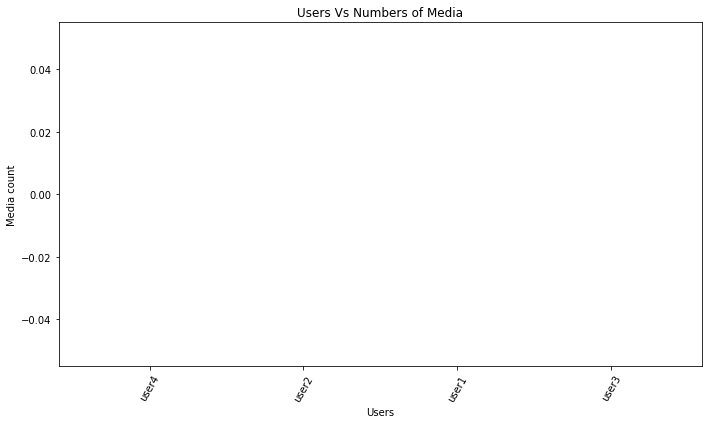

In [82]:
custom_display("Total media shared: "+ str(total_medias_sent))
#custom_display("User X" + " has sent highest number of medias with a count of "+ str(temp_users_df['total_media_sent'].iloc[0])+ " medias which is "+ str(round((users_df['total_media_sent'].iloc[0]/total_medias_sent)*100.0,2))+"% of the total medias")
custom_display(temp_users_df['user'].iloc[0] + " has sent highest number of medias with a count of "+ str(temp_users_df['total_media_sent'].iloc[0])+ " medias which is "+ str(round((users_df['total_media_sent'].iloc[0]/total_medias_sent)*100.0,2))+"% of the total medias")
media_count_by_users = temp_users_df.total_media_sent[:number_of_users_to_be_shown].tolist()
user_names = temp_users_df.user[:number_of_users_to_be_shown].tolist()
# user_names = []
# for i in range(number_of_users_to_be_shown):
#     user_names.append('user'+str(i))

plot_bar_chart(number_of_users_to_be_shown, media_count_by_users, user_names, 'Users Vs Numbers of Media', 'Users', 'Media count', rotation=60)

## Smiley Analysis

In [83]:
smileys = '😀😃😄😁😆😅😂🤣😊😇🙂🙃😉😌😍😘😗😙😚😋😛😝😜🤪🤨🧐🤓😎🤩😏😒😞😔😟😕🙁😣😖😫😩😢😭😤😠😡🤬🤯😳😱😨😰😥😓🤗🤔🤭🤫🤥😶😐😑😬🙄😯😦😧😮😲😴🤤😪😵🤐🤢🤮🤧😷🤒🤕🤑🤠😈👿👹👺🤡💩👻💀☠👽👾🤖🎃😺😸😹😻😼😽🙀😿😾🤲👐🙌👏🤝👍👎👊✊🤛🤜🤞✌🤟👌👈👉👆☝✋🤚🖐🖖👋🤙💪🖕✍🙏💍💄💋👄👅👂👃👣👁👀🧠🗣👤👥👶👧🧒👦👩🧑👨🧔👵🧓👴🙇‍💁‍💁‍🙅‍🙅‍🙆‍🙆‍🙋‍🙋‍🤦‍🤦‍🤷‍🤷‍🙎‍🙎‍🙍‍🙍‍💇‍💇‍💆‍💆‍🧖‍🧖‍💅🤳💃🕺👯‍👯‍🕴🚶‍🚶‍🏃‍🏃‍👫👭👬💑👩‍❤‍👩👨‍❤‍👨💏👩‍💋‍👩👨‍💋‍👪👨‍👩‍👧👨‍👩‍👧‍👦👨‍👩‍👦‍👦👨‍👩‍👧‍👧👩‍👩‍👦👩‍👩‍👧👩‍👩‍👧‍👦👩‍👩‍👦‍👦👩‍👩‍👧‍👧👨‍👨‍👦👨‍👨‍👧👨‍👨‍👧‍👦👨‍👨‍👦‍👦👨‍👨‍👧‍👧👩‍👦👩‍👧👩‍👧‍👦👩‍👦‍👦👩‍👧‍👧👙👑🐶🐵🙈🙉🙊🐒🌹⚽🏋‍🏋‍🤼‍🤼‍❤💔❣🧡💛💚💙💜💕💞💓💗💖💘💝💟✝☪🕉☸✡🔯💯'

In [103]:
smiley_data = {}
for smiley in smileys:
    cnt = len(re.findall(r'' + smiley+ '', data))
    if cnt > 0:
        smiley_data[smiley]=cnt

In [85]:
ordered_smileys_by_usage_dict = sort_by_values(smiley_data)
smileys_count_list = list(ordered_smileys_by_usage_dict.values())
total_smileys_used = sum(smileys_count_list)
custom_display("Total smileys sent: "+ str(total_smileys_used))

Total smileys sent: 0


In [86]:
top_n_smileys=10
if total_smileys_used > 0:
    top_n_smileys_percentage = np.round((sum(smileys_count_list[:top_n_smileys])/total_smileys_used)*100.0)
    display(HTML(("<h2>Top "+ str(top_n_smileys) + " used smileys:</h2>")))
    print(list(ordered_smileys_by_usage_dict.keys())[:top_n_smileys])
    top_n_smileys_percentage = np.round((sum(smileys_count_list[:top_n_smileys])/total_smileys_used)*100.0)
    custom_display("And these smileys constitute " + str(top_n_smileys_percentage)+ "% of the total smileys sent")

In [87]:
html_table = """
<table style="font-family: arial, sans-serif;border-collapse: collapse;width: 100%;">
    <tbody>
        <tr>
            <th style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>Smiley</th>
            <th style='border: 1px solid #dddddd;text-align: left;padding: 8px;'> Percentage </th>
        </tr>            
"""
for smiley in list(ordered_smileys_by_usage_dict.keys())[:top_n_smileys]:
    html_table += "<tr>"
    html_table += "<td style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>" + str(smiley) + "</td>"
    html_table += "<td style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>" + str(round((ordered_smileys_by_usage_dict[smiley]/total_smileys_used)*100.0, 3)) + "%</td>"
    html_table += "</tr>"
html_table += "</tbody></table>"
display(HTML(html_table))

Smiley,Percentage


# Tag analysis

In [88]:
tagged_people_count = {} # 'contact_number': count
people_who_tags_others = {} # 'contact_number': [contact_number, contact_number]

In [89]:
for user_id in users_df.id:
    messages = ' '.join(content_df[content_df['user_id'] == user_id]['message_modified'].tolist())
    tags = [txt[1:] for txt in re.findall(r'@\d{8,15}', messages)]
    contact_name = users_df[users_df['id'] == user_id]['user'].tolist()[0]
    if len(tags) > 0:
        tagged_people_count[contact_name] = len(tags)
        people_who_tags_others[contact_name] = tags

In [90]:
tagged_people_count = sort_by_values(tagged_people_count)
total_tag_count = sum(list(tagged_people_count.values()))

## Top users who tags others 

In [91]:
top_users_count = 3
html_table = """
<table style="font-family: arial, sans-serif;border-collapse: collapse;width: 100%;">
    <tbody>
        <tr>
            <th style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>Name</th>
            <th style='border: 1px solid #dddddd;text-align: left;padding: 8px;'> Tag count </th>
        </tr>            
"""
for user_name in list(tagged_people_count.keys())[:top_users_count]:
    html_table += "<tr>"
    html_table += "<td style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>" + user_name + "</td>"
    html_table += "<td style='border: 1px solid #dddddd;text-align: left;padding: 8px;'>" + str(tagged_people_count[user_name]) + " ("+ str(np.round((tagged_people_count[user_name]/total_tag_count)*100.0, 2))+"% of total tags)</td>"
    html_table += "</tr>"
html_table += "</tbody></table>"

people_who_are_tagged_in_chats = []
for key in people_who_tags_others.keys():
    people_who_are_tagged_in_chats+= people_who_tags_others[key]

In [92]:
if len(people_who_are_tagged_in_chats) > 0:
    tag_count = sort_by_values(Counter(people_who_are_tagged_in_chats))
    most_tagged_contact = list(tag_count)[0]

    custom_display("Total tags: " + str(total_tag_count))
    display(HTML("<h3>Top list of users who tags others</h3><br>" + html_table))
    custom_display(str(most_tagged_contact) + " is the most tagged person with a tag count of " + str(tag_count[most_tagged_contact]) + " which is " + str(np.round((tag_count[most_tagged_contact]/total_tag_count)*100.0, 2)) + "% of the total tags" )
#     custom_display("User X" + " is the most tagged person with a tag count of " + str(tag_count[most_tagged_contact]) + " which is " + str(np.round((tag_count[most_tagged_contact]/total_tag_count)*100.0, 2)) + "% of the total tags" )
else:
    custom_display("No one tagged anyone")    

No one tagged anyone
